In [1]:
import numpy as np
import os

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import time

## Reading


In [3]:
def read_pbm(filename):
    with open(filename, 'r', encoding = 'utf-8') as f:

        # Read the header
        magic_number = f.readline().strip()
        if magic_number != 'P1':
            raise ValueError("File is not a valid ASCII PBM (P1) file.")
        
        # Skip comments
        line = f.readline()
        while line.startswith('#'):
            line = f.readline()
        
        # Read dimensions
        width, height = map(int, line.split())
        
        # Read pixel data
        pixels = []
        for line in f:
            pixels.extend(line.split())
        
    # Convert to numpy array and reshape
    image = np.array(pixels, dtype=int).reshape((height, width))
    return image

In [4]:
def write_pbm(image, filename):
    with open(filename, 'w') as f:
        f.write("P1\n")
        f.write("16 16\n")
        for row in image:
            for el in row:
                if el == 0:
                    f.write("0 ")
                else:
                    f.write("1 ")
            f.write("\n")



In [5]:
pbm_files = [f for f in os.listdir("pbm_files")]

In [6]:
pbm_files # array of file names

['image_1.pbm', 'image_2.pbm', 'image_3.pbm', 'image_4.pbm']

In [7]:
train_images = [] # array of images, each image as numpy array, so array of numpy arrays
for file in pbm_files: 
    train_images.append(read_pbm("pbm_files/" + file))


In [8]:
#write_pbm(train_images[0], "test.pbm") #write function, not used in code

## Display Function

In [9]:
def display_image(image): #function to display image
    # Reshape to 16x16 for visualization
    image = image.reshape(16, 16)

    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()


## Training


In [10]:
weights = np.zeros((256, 256)) #initializing weights matrix

for img in train_images:
    img_vector = img.flatten() * 2 - 1 #to convert 0, 1 to -1, 1
    weights += np.outer(img_vector, img_vector) # same as img_vector @ img_vector.T but better data form

for i in range(256):
    weights[i][i] = 0

weights = weights/len(train_images) #dividing by number of training images


## Memory Corruption Functions

In [11]:
def random_flip(image, p):
    corrupted = image.copy()
    flip_bool = np.random.rand(16, 16) < p # bool 16x16 to figure which ones to flip

    corrupted[flip_bool] = 1 - corrupted[flip_bool]
    return corrupted
    

In [12]:
def corrupt_crop(image, box_size):
    corrupted = np.zeros((16,16))
    start = (16 - box_size) // 2
    corrupted[start:start+box_size, start:start+box_size] = image[start:start+box_size, start:start+box_size]
    return corrupted

## Update Functions

In [13]:
def sync_update(image): # returns in image back -1 and 1 # returns final state and number of iterations
    theta = 0 #threshold
    
    state = (image.flatten() * 2 - 1).astype(int) #to convert to 1 and -1
    orignal_state = state.copy()
    iterations = 100
    for i in range(iterations):
        new_state = np.where(weights @ state >= theta, 1, -1) #update function

        if np.array_equal(new_state, state): # if function to break when we reach convergence
            break
        state = new_state 
        #display_image(state)

    #print("Number of iterations it took to converge: ", i)
    return state.reshape(16, 16), i


In [14]:
def async_update(image, iterations=1000): # returns final state and number of iterations
    theta = 0
    state = image.flatten() * 2 - 1  # Convert to {-1, 1}

    for its in range(iterations):
        i = np.random.randint(256)  # Random neuron index
        sum_input = np.dot(weights[i], state)
        
        if sum_input >= theta:
            state[i] = 1
        else:
            state[i] = -1

        if its%100 == 0: #state every 100 iterations
            display_image(state)
            
    print("Number of iterations it took to converge: ", its)

    return (state.reshape(16, 16) + 1) // 2, its  # Convert back to 0 and 1


## Running the Algorithm

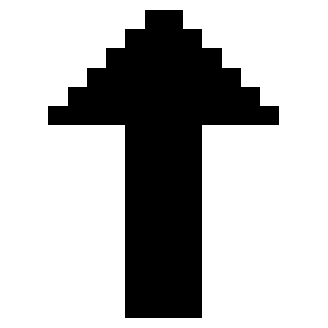

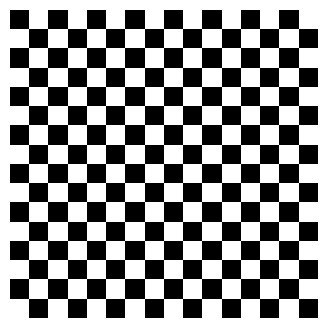

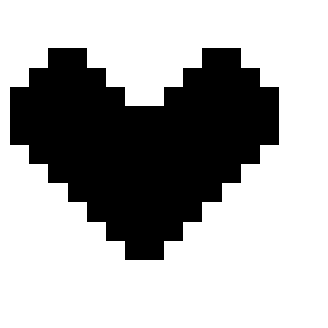

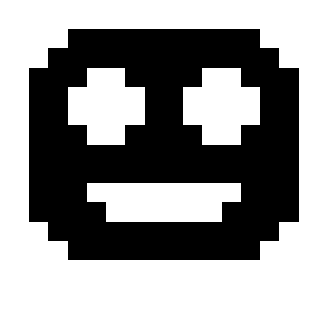

In [15]:
for img in train_images: #displaying all train images
    display_image(img)

In [16]:
weights #checking weights vector to check if it was populated

array([[0. , 0.5, 1. , ..., 1. , 0.5, 1. ],
       [0.5, 0. , 0.5, ..., 0.5, 1. , 0.5],
       [1. , 0.5, 0. , ..., 1. , 0.5, 1. ],
       ...,
       [1. , 0.5, 1. , ..., 0. , 0.5, 1. ],
       [0.5, 1. , 0.5, ..., 0.5, 0. , 0.5],
       [1. , 0.5, 1. , ..., 1. , 0.5, 0. ]])

# Task 2:

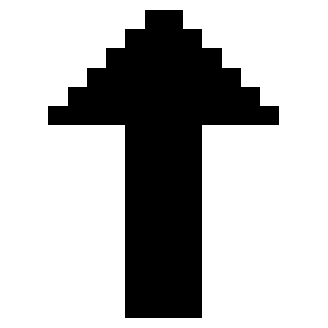

In [17]:
image = train_images[0]
display_image(image)

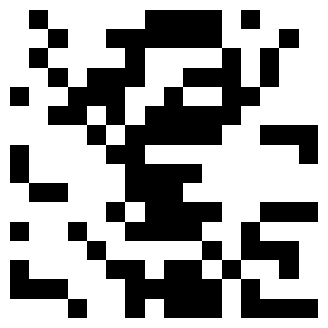

In [18]:
random_flipped_image = random_flip(image, 0.3)
display_image(random_flipped_image)

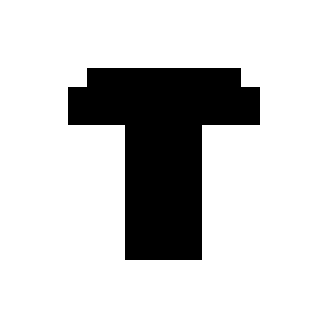

In [19]:
cropped_image = corrupt_crop(image, 10)
display_image(cropped_image)

### Synchronous Update for p = 0.3

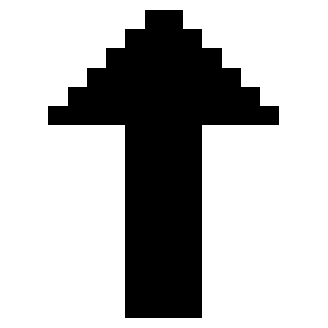

In [20]:
display_image(sync_update(random_flipped_image)[0])

### Synchronous Update for cropped out image

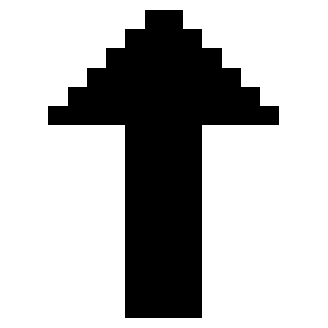

In [21]:
display_image(sync_update(cropped_image)[0])

### Asynchronous Update for p = 0.3

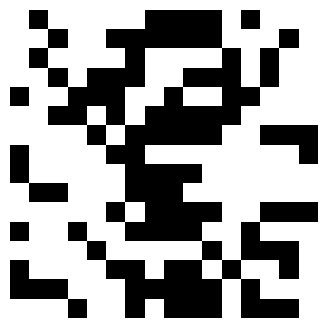

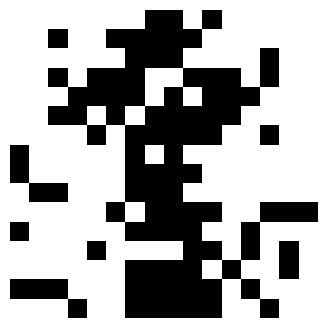

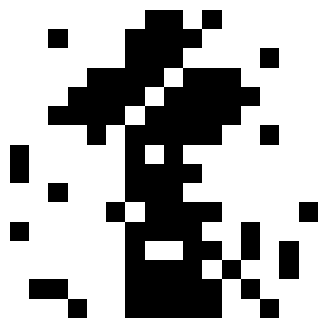

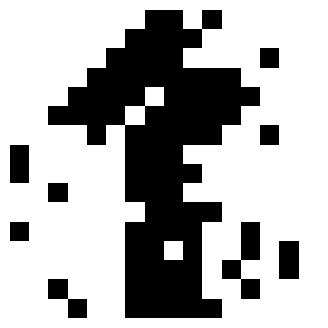

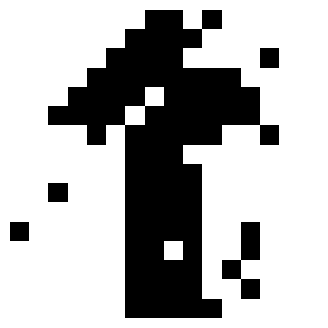

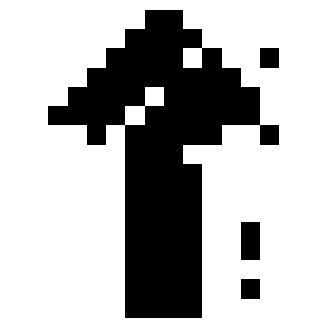

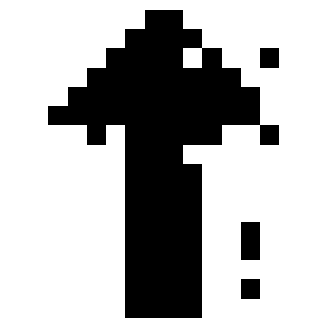

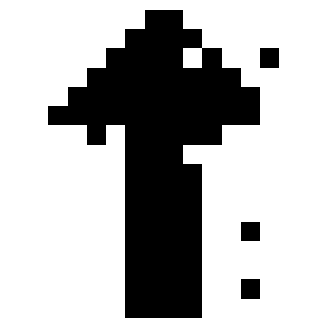

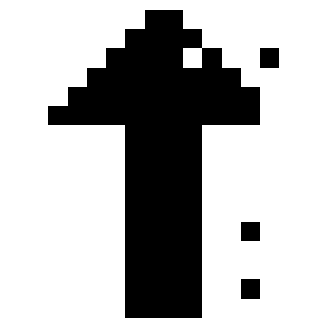

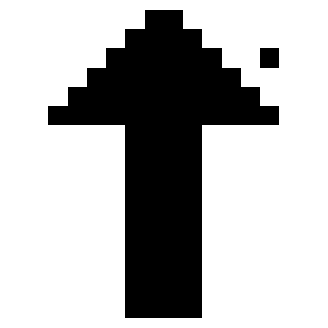

Number of iterations it took to converge:  999


(array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]], dtype=int32),
 999)

In [22]:
async_update(random_flipped_image)

### Asynchronous Update for cropped out image

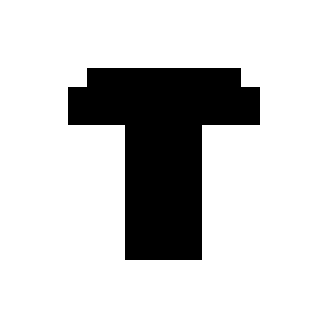

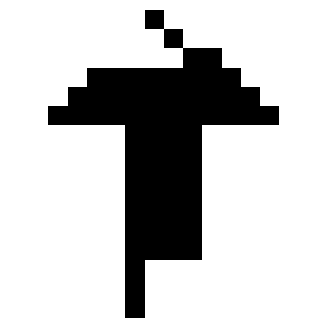

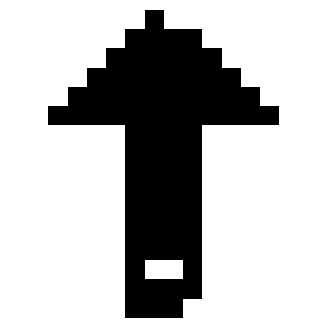

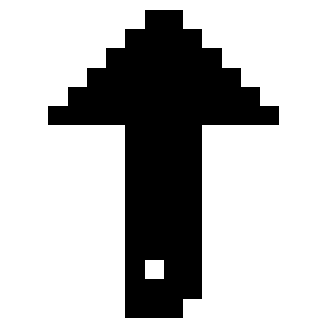

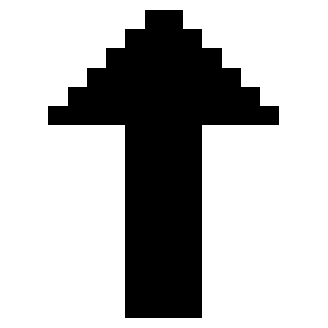

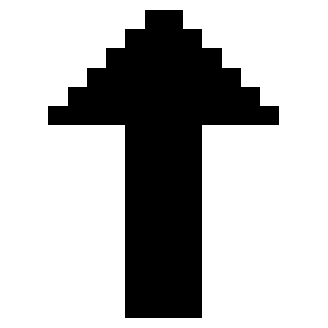

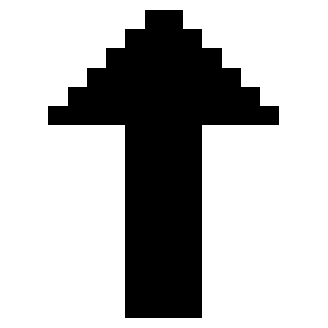

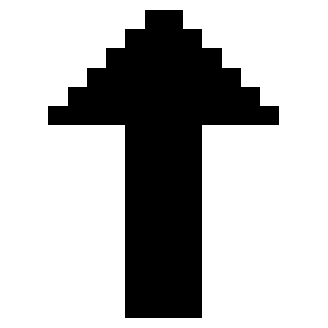

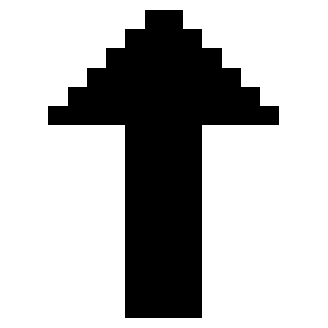

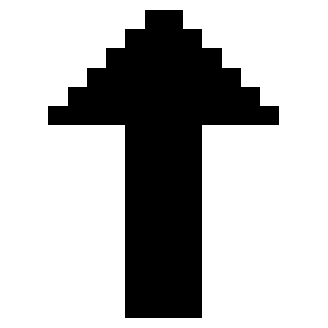

Number of iterations it took to converge:  999


(array([[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1

In [23]:
async_update(cropped_image)

## Task 3:

In [24]:
probabilities = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
correct_convergence_result = [] # array of 1s and 0s for whether it converged correctly or not, will be reshaped and summed up later
results = [] #an array of 2-tuples for each update in the format [no. of iterations, convergence result]

for p in probabilities:
    for im in train_images:
        for _ in range(20):
            flag = 0 #convergence result stored here
            cim = random_flip(im, p)
            op = sync_update(cim)
            if np.array_equal(op[0], im * 2 - 1):
                #print("Correctly converged")
                correct_convergence_result.append(1)
                flag = 1
            else:
                correct_convergence_result.append(0)
            results.append([op[1], flag]) 

In [25]:
correct_convergence_result = np.array(correct_convergence_result)
correct_convergence_result = correct_convergence_result.reshape(8, 80)

In [26]:
arr = [] # stores number of successful converges for each prob value
for row in correct_convergence_result:
    temp = 0
    for el in row:
        temp += el
    arr.append(temp)

arr

[80, 78, 52, 6, 0, 0, 0, 0]

### Plotting successful converges against each probability

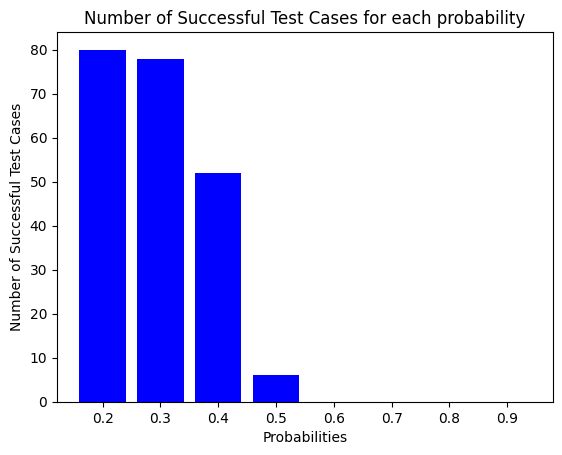

In [27]:
categories = [str(p) for p in probabilities]
values = arr

plt.bar(categories, values, color='blue')

plt.xlabel('Probabilities')
plt.ylabel('Number of Successful Test Cases')
plt.title('Number of Successful Test Cases for each probability')

plt.show()


### For each probability individually

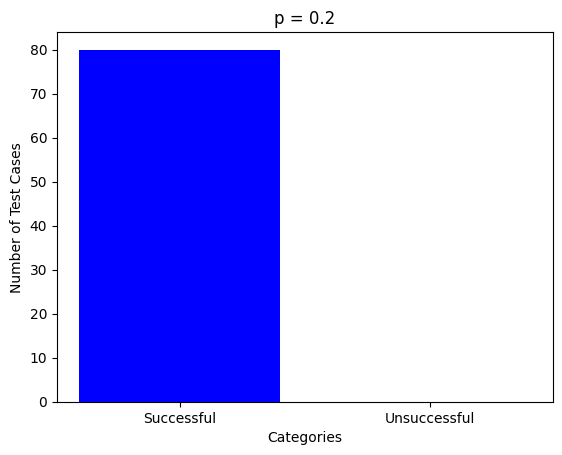

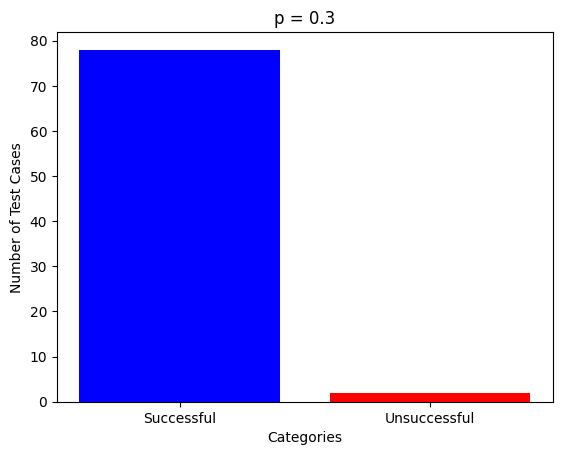

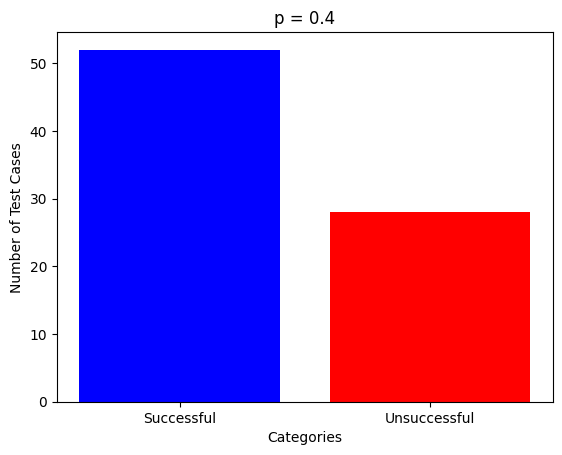

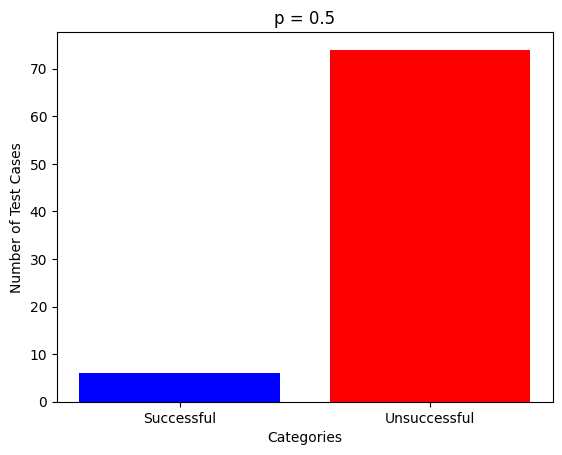

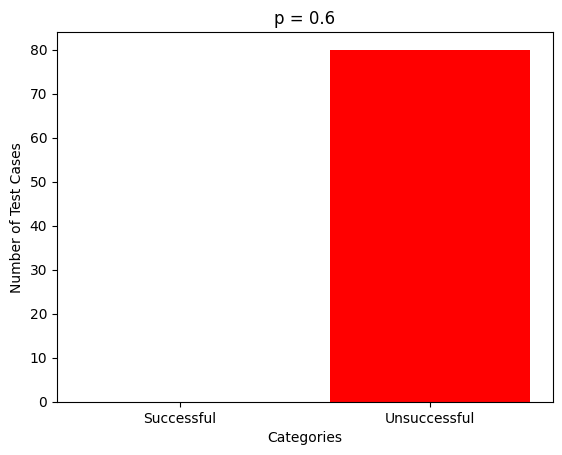

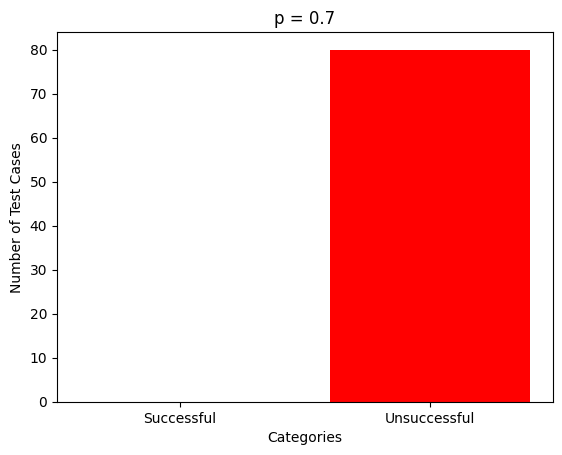

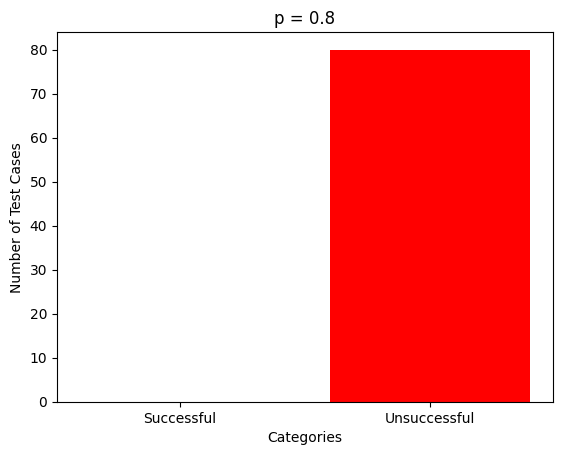

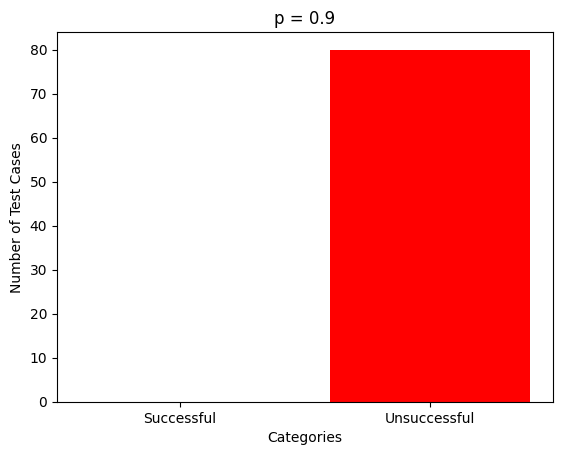

In [28]:

categories = ['Successful', 'Unsuccessful']

pointer = 0
for i, el in enumerate(arr):
    values = [el, 80 - el]

    plt.bar(categories, values, color=['blue', 'red'])

    plt.xlabel('Categories')
    plt.ylabel('Number of Test Cases')
    plt.title(f'p = {probabilities[i]}')

    plt.show()


### Plotting average number of iterations of successful convergences for each probability

In [29]:
results = np.array(results)
results = results.reshape(8, 80, 2)

In [30]:
num_iterations = []

for row in results:
    temp = 0
    count = 0
    for el in row:
        if el[1] == 1: #successful
            temp += el[0]
            count += 1
    if count == 0: count = 1
    num_iterations.append(temp/count)

num_iterations

##note: 0 indicates undefined value as there were no successful convergences

[1.0125,
 1.0256410256410255,
 1.1538461538461537,
 1.8333333333333333,
 0.0,
 0.0,
 0.0,
 0.0]

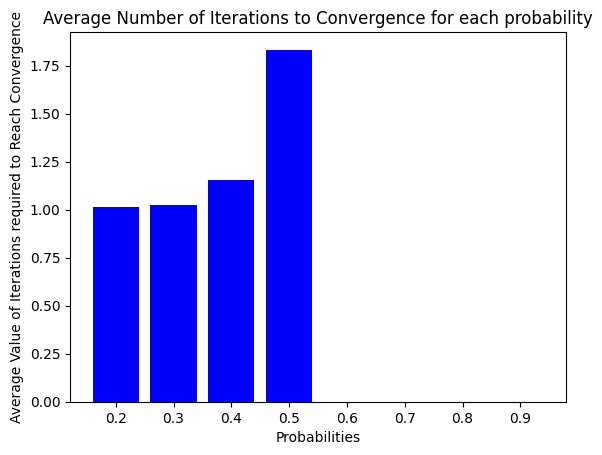

In [31]:

categories = [str(p) for p in probabilities]
values = num_iterations

plt.bar(categories, values, color='blue')

plt.xlabel('Probabilities')
plt.ylabel('Average Value of Iterations required to Reach Convergence')
plt.title('Average Number of Iterations to Convergence for each probability')

plt.show()
